In [1]:
import pandas as pd
from utils.data_processing import EyeTrackingProcessor, GazeMetricsProcessor, MouseMetricsProcessor
import matplotlib.pyplot as plt

import numpy as np
import os
from tqdm import tqdm
from typing import Union, Dict, Tuple
from pathlib import Path

****
# Initial Processing
****

- For conflict detection, we just have a start marker because the detection itself is a very short moment. It is probably scanning befaire the actual task execution. How to measure it ?
- rgd speed vector does not have a start and end because it's when the ATCO clicked on the speed vector. Not a task itself but often the start of conflict resolution process. It is and additional HMI information. 

## Things to watchout for:
- Some tasks might be contained within other tasks. -> Try to detect them. 
- Event speed vector change is an HMI information, not a task
- No columns participant name.
- Column names have now the units -> names have changed
- recording timestamp in ms and not microseconds.
- Task range can account for overlapping tasks but only one active instance per task type:
    - Task 1 start Task 2 start Task 2 end Task 1 end -> OK
    - Task 1 start Task 1 start Task 1 end Task 1 end -> NOT OK because will overwrite the first Task 1
    - New version can handle overlapping of the same task bu assume that the current end is mattched with the most recent unmatched start
    - For overlaps of different tasks, task_range_finder old and news are the same.
- Is it really realistic that we can have overlapping tasks? Can one specific gaze observation be associated with two tasks really ? 
    - Old get_feature function doesn't handle overlapping task. One observation is associated to only one task.
    - New get_features function handle it by outputing a dict whose key is the task id, and the value the corresponding chunk of the dataframe. 
    - For real-time implementation, do the same with fixed size chunks (ex 3s), ans assign the mos present task during those 3s.
    - The problem with overlapping is that we can have label leakage, and therefore one observation can be used to classify 2 different tasks. We really have to discuss it together. 

In [16]:
data_path = "/store/kruu/eye_tracking/atco_hungary"
features = ['Recording timestamp [ms]', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]', 'Event']
interpolate_cols = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]', "Blink"]
fill_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']

def load_and_process(data_path: Union[str, Path],
                     columns: list[str],
                     interpolate_cols: list[str],
                     fill_cols: list[str],
                     time_resampling: bool = True
                     ) -> pd.DataFrame:
    
    files_list = os.listdir(data_path)
    files_list = [os.path.join(data_path, file) for file in files_list if file.endswith(".tsv")]
    
    processor = EyeTrackingProcessor()
    all_data, atco_task_map = processor.load_data(files_list)
    chunks = processor.get_features(all_data, columns)
    chunks, blinks = processor.detect_blinks(chunks)
    
    # Fixed Time step resampling
    if time_resampling: 
        resampled_chunks_time = processor.resample_task_chunks(chunks, interpolate_cols, mode="time", param=10)

        for task_id, chunk in resampled_chunks_time.items():
            resampled_chunks_time[task_id].Blink = (resampled_chunks_time[task_id].Blink > 0.5) #Transform interpolated data
            for col in fill_cols:
                resampled_chunks_time[task_id][col] = resampled_chunks_time[task_id][col].ffill().bfill()
            
        return resampled_chunks_time, blinks, atco_task_map
    return chunks, blinks, atco_task_map

chunks_xgboost, blinks, atco_task_map = load_and_process(data_path, features, interpolate_cols, fill_columns, time_resampling=False)

In [17]:
atco_task_map

{'Aircraft requests': 'Task 0',
 'Conflict resolution': 'Task 1',
 'Coordination response': 'Task 2',
 'QoS': 'Task 3',
 'Return to route': 'Task 4',
 'assume': 'Task 5',
 'transfer': 'Task 6'}

In [18]:
chunks_xgboost["1_6_0"]

,Recording timestamp [ms],Gaze point X [DACS px],Gaze point Y [DACS px],Mouse position X [DACS px],Mouse position Y [DACS px],Event,Task_id,Task_execution,Participant name,id,Blink,Loss of Attention
0,514239,NaN,NaN,NaN,NaN,Task 6,6,0,1,1_6_0,1,True
1,514247,900.0,433.0,NaN,NaN,NaN,6,0,1,1_6_0,1,True
2,514255,902.0,426.0,NaN,NaN,NaN,6,0,1,1_6_0,1,True
3,514263,910.0,434.0,NaN,NaN,NaN,6,0,1,1_6_0,1,True
4,514272,906.0,441.0,NaN,NaN,NaN,6,0,1,1_6_0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
3602,542521,897.0,372.0,NaN,NaN,NaN,6,0,1,1_6_0,1,True
3603,542530,891.0,396.0,NaN,NaN,NaN,6,0,1,1_6_0,1,True
3604,542538,891.0,360.0,NaN,NaN,NaN,6,0,1,1_6_0,1,True
3605,542546,895.0,366.0,NaN,NaN,NaN,6,0,1,1_6_0,1,True


In [19]:
from collections import defaultdict

def find_overlapping_tasks(task_chunks: dict[str, pd.DataFrame]) -> dict[int, list[tuple[str, str]]]:
    # Organize tasks per participant
    participant_tasks = defaultdict(list)

    for task_id, df in task_chunks.items():
        if df.empty:
            continue

        participant = df["Participant name"].iloc[0]
        start_time = df["Recording timestamp [ms]"].min()
        end_time = df["Recording timestamp [ms]"].max()
        participant_tasks[participant].append((task_id, start_time, end_time))

    # Detect overlaps/nesting
    overlaps_per_participant = defaultdict(list)

    for participant, tasks in participant_tasks.items():
        n = len(tasks)
        for i in range(n):
            id1, start1, end1 = tasks[i]
            for j in range(i + 1, n):
                id2, start2, end2 = tasks[j]

                # Check for overlap
                if start1 <= end2 and start2 <= end1:
                    overlaps_per_participant[participant].append((id1, id2))

    return overlaps_per_participant

overlaps = find_overlapping_tasks(chunks_xgboost)
for participant, overlapping_pairs in overlaps.items():
    print(f"Participant {participant} has overlapping tasks:")
    for t1, t2 in overlapping_pairs:
        print(f"  - {t1} overlaps with {t2}")

Participant 0 has overlapping tasks:
  - 0_5_0 overlaps with 0_1_0
  - 0_5_1 overlaps with 0_1_0
  - 0_5_2 overlaps with 0_1_0
  - 0_5_9 overlaps with 0_1_1
  - 0_5_11 overlaps with 0_1_2
  - 0_5_12 overlaps with 0_1_4
  - 0_5_12 overlaps with 0_1_5
  - 0_5_12 overlaps with 0_2_0
  - 0_5_13 overlaps with 0_6_4
  - 0_5_13 overlaps with 0_6_5
  - 0_5_14 overlaps with 0_6_5
  - 0_1_4 overlaps with 0_2_0
  - 0_1_6 overlaps with 0_6_6
Participant 1 has overlapping tasks:
  - 1_5_0 overlaps with 1_1_0
  - 1_5_1 overlaps with 1_1_0
  - 1_5_2 overlaps with 1_1_0
  - 1_5_9 overlaps with 1_1_1
  - 1_5_11 overlaps with 1_1_2
  - 1_5_12 overlaps with 1_1_4
  - 1_5_12 overlaps with 1_1_5
  - 1_5_12 overlaps with 1_2_0
  - 1_5_13 overlaps with 1_6_4
  - 1_5_13 overlaps with 1_6_5
  - 1_5_14 overlaps with 1_6_5
  - 1_1_4 overlaps with 1_2_0
  - 1_1_6 overlaps with 1_6_6
Participant 2 has overlapping tasks:
  - 2_5_0 overlaps with 2_1_0
  - 2_5_1 overlaps with 2_1_0
  - 2_5_2 overlaps with 2_1_0
  - 2

****
# PLot Raw Data
****

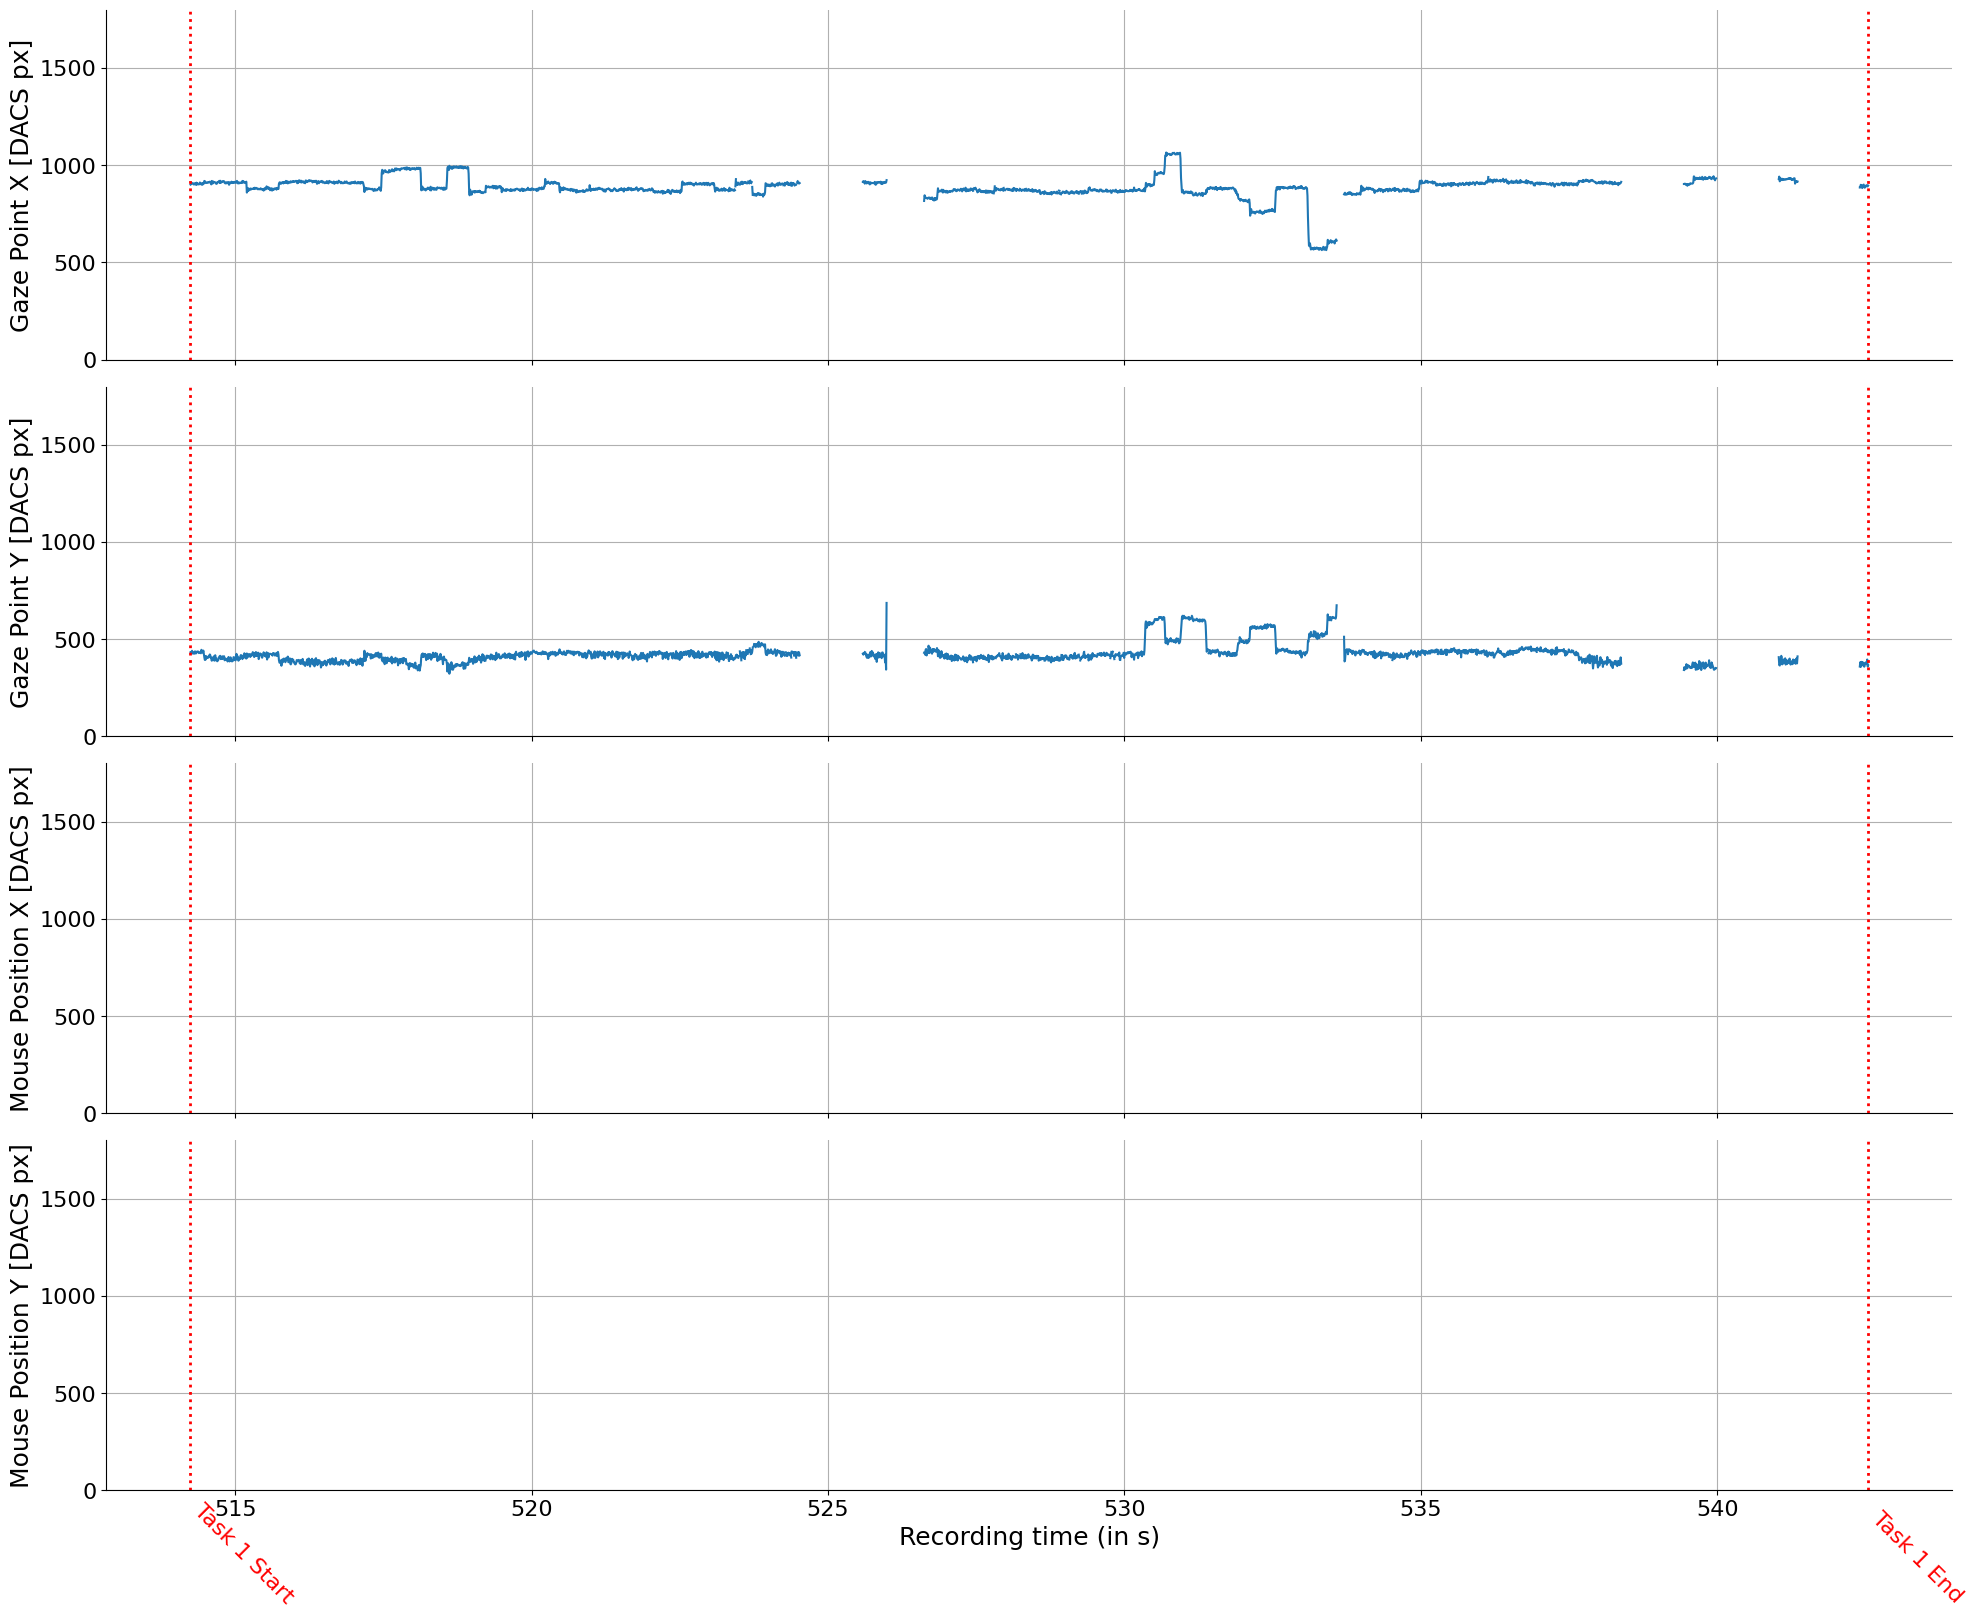

In [20]:
id_task = "0_6_0"
task_plot = chunks_xgboost[id_task]

fig, axs = plt.subplots(4, 1, figsize=(20, 16), sharex=True)
# Convert timestamps to seconds
timestamps_sec = task_plot["Recording timestamp [ms]"] / 1e3
start_time_sec = task_plot.iloc[0]["Recording timestamp [ms]"] / 1e3
end_time_sec = task_plot.iloc[-1]["Recording timestamp [ms]"] / 1e3

# Titles for each subplot
titles = ['Gaze Point X [DACS px]', 'Gaze Point Y [DACS px]', 'Mouse Position X [DACS px]', 'Mouse Position Y [DACS px]']
data_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']

# Plot each subplot
for ax, title, col in zip(axs, titles, data_columns):
    ax.plot(timestamps_sec, task_plot[col], label=title)
    ax.axvline(x=start_time_sec, color='red', linestyle=':', linewidth=2)
    ax.axvline(x=end_time_sec, color='red', linestyle=':', linewidth=2)
    ax.set_ylim(0, 1800)
    ax.set_ylabel(title)
    ax.grid(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Add labels directly to vertical lines on the top subplot only
axs[-1].text(start_time_sec, -600, 'Task 1 Start', color='red', rotation=-45, verticalalignment='bottom', fontsize = 16)
axs[-1].text(end_time_sec, -600, 'Task 1 End', color='red', rotation=-45, verticalalignment='bottom', fontsize = 16)

# X-axis label on the last subplot
axs[-1].set_xlabel('Recording time (in s)', fontsize = 18)

for ax in axs:
    ax.tick_params(axis='both', labelsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)

plt.tight_layout()
plt.show()

****
# Blink detection
****

Note: 
- Blink id are note necessrily consecutive because we can have missing gaze values that are not long enough to constitute a blink 
- Blink if between 100ms and 400ms. If longer, it's a loss of attention. If lower, it's not considered.

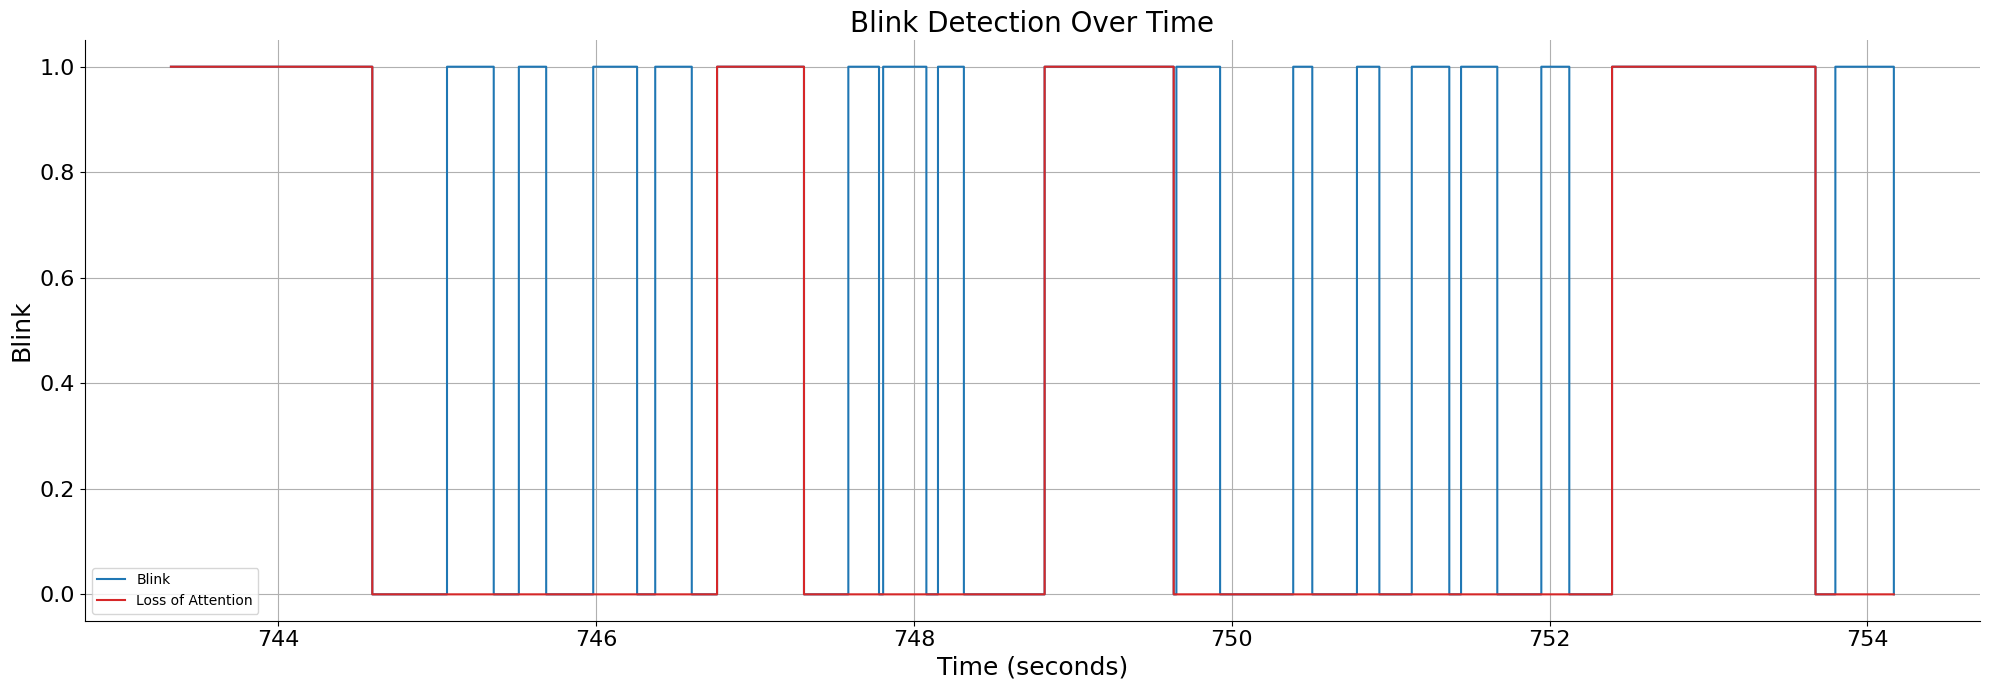

In [21]:
task_plot = chunks_xgboost['0_1_2']

fig, ax = plt.subplots(1, 1, figsize=(20, 7), sharex=True)
# Convert timestamps to seconds
timestamps_sec = task_plot["Recording timestamp [ms]"] / 1e3

ax.step(timestamps_sec, task_plot["Blink"], label="Blink", where="post", color='tab:blue')
ax.step(timestamps_sec, task_plot["Loss of Attention"], label="Loss of Attention", where="post", color='tab:red')
ax.set_ylabel("Blink", fontsize=18)
ax.set_xlabel("Time (seconds)", fontsize=18)
ax.set_title("Blink Detection Over Time", fontsize=20)
ax.grid(True)
ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='both', labelsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)

plt.tight_layout()
plt.show()

In [22]:
blinks['0_1_2']

,Blink ID,Time Diff,Attention State,Loss of Attention
0,1,1259.0,Loss of attention,True
22,23,292.0,Blink,False
33,34,175.0,Blink,False
51,52,275.0,Blink,False
59,60,234.0,Blink,False
70,71,542.0,Loss of attention,True
86,87,192.0,Blink,False
88,89,275.0,Blink,False
94,95,158.0,Blink,False
123,124,809.0,Loss of attention,True


****
# Interpolated Data + XGBoost processing 
****

In [23]:
fill_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']
for task_id, chunk in chunks_xgboost.items():
    for col in fill_columns:
        chunks_xgboost[task_id][col] = chunks_xgboost[task_id][col].ffill().bfill()

In [24]:
# Manual feature extraction

gaze_metrics = []
mouse_metrics = []
for task_id, chunk in chunks_xgboost.items():
    gaze_processor = GazeMetricsProcessor(chunk, timestamp_unit="ms")
    gaze_compute = gaze_processor.compute_all_metrics()
    gaze_compute.update({"id": task_id})
    gaze_metrics.append(gaze_compute)
    
    mouse_processor = MouseMetricsProcessor(chunk, timestamp_unit="ms")
    mouse_compute = mouse_processor.compute_all_metrics()
    mouse_compute.update({"id": task_id})
    mouse_metrics.append(mouse_compute)
gaze_metrics_df = pd.DataFrame(gaze_metrics)
mouse_metrics_df = pd.DataFrame(mouse_metrics)


In [25]:
# TS fresh
columns_to_extract = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']

# The chunks were bfill and ffill before. Of course there are very few zeros.
def drop_chunks_with_all_zero_features(task_chunks: dict[str, pd.DataFrame], threshold: float = 1.0) -> dict[str, pd.DataFrame]:
    """
    Drops any DataFrame from the dict where at least one feature column has a great proportion of zero.
    
    Parameters
    ----------
    task_chunks : dict[str, pd.DataFrame]
        Dictionary with task ID as key and task data as value.
    threshold: float
        Proportion of zeros required to drop a feature
    
    Returns
    -------
    dict[str, pd.DataFrame]
        Filtered dictionary with problematic chunks removed.
    """
    feature_cols = ["Gaze point X", "Gaze point Y", "Mouse position X", "Mouse position Y"]
    cleaned_chunks = {}
    dropped_ids = []
    for task_id, df in task_chunks.items():
            present_cols = [col for col in feature_cols if col in df.columns]
            drop = False

            for col in present_cols:
                zero_ratio = (df[col] == 0).mean()  # proportion of zeros
                if zero_ratio >= threshold:
                    drop = True
                    break

            if drop:
                dropped_ids.append(task_id)
            else:
                cleaned_chunks[task_id] = df

    if dropped_ids:
        print(f"Dropped {len(dropped_ids)} chunks (threshold={threshold}):", dropped_ids)
    else:
        print(f"No chunks dropped (threshold={threshold}).")

    return cleaned_chunks

cleaned_task_chunks = drop_chunks_with_all_zero_features(chunks_xgboost, threshold=0.95)

No chunks dropped (threshold=0.95).


In [26]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction import MinimalFCParameters

def detect_timestamp_column(df: pd.DataFrame) -> str:
    candidates = [col for col in df.columns if "Recording timestamp" in col]
    if not candidates:
        raise ValueError("No 'Recording timestamp' column found.")
    return candidates[0] 

def extract_tsfresh_features_from_chunks(
    task_chunks: dict[str, pd.DataFrame],
    columns_to_extract: list[str],
    pval_threshold: float = 0.05,
    n_jobs: int = 4
) -> pd.DataFrame:
    """
    Extract and select TSFresh features from a dictionary of task chunks.

    Parameters:
    - task_chunks: dict with `id` as key and corresponding df as value
    - columns_to_extract: list of features to use in TSFresh
    - pval_threshold: p-value threshold for relevance filtering
    - n_jobs: number of parallel jobs for TSFresh

    Returns:
    - final_features: DataFrame of filtered, selected features with `id` as index
    """
    # Step 1: Recombine into one DataFrame
    # Concatenate everything in one single df for TSFresh
    # Rows are dupplicated if we have overlapping tasks
    full_df = pd.concat(task_chunks.values(), ignore_index=True)
    timestamp_col = detect_timestamp_column(full_df)

    # Step 2: Run TSFresh
    print("Extracting TSFresh features...")
    extracted_features = extract_features(
        full_df[["id", timestamp_col] + columns_to_extract],
        column_id="id",
        column_sort=timestamp_col,
        default_fc_parameters=MinimalFCParameters(), 
        n_jobs=n_jobs,
        disable_progressbar=False
    )

    # Step 3: Impute missing features
    impute(extracted_features)

    # Step 4: Define target variable (from original task chunks)
    task_labels = full_df.groupby("id")["Task_id"].first()

    # Step 5: Relevance filtering
    relevant_features = calculate_relevance_table(extracted_features, task_labels)
    selected_features = relevant_features[relevant_features["p_value"] < pval_threshold]["feature"]
    
    # Step 6: Final filtered feature matrix
    final_features = extracted_features[selected_features].reset_index(names="id")

    return final_features

tsfresh_data = extract_tsfresh_features_from_chunks(cleaned_task_chunks, columns_to_extract, pval_threshold=0.05, n_jobs=50)


Extracting TSFresh features...


Feature Extraction: 100%|██████████| 220/220 [00:00<00:00, 464.27it/s]


In [29]:
xgboost_data = gaze_metrics_df.merge(mouse_metrics_df, on="id")
xgboost_data = xgboost_data.merge(tsfresh_data, on="id")

In [31]:
xgboost_data

,Fixation Count,Total Fixation Duration (s),Avg Fixation Duration (s),Saccade Count,Avg Saccade Amplitude (px),Avg Saccade Velocity (px/s),Avg Gaze Velocity (px/s),Avg Gaze Acceleration (px/s²),Blink Rate (blinks/s),Gaze Dispersion (area_px²),...,Mouse position Y [DACS px]__standard_deviation,Mouse position Y [DACS px]__variance,Gaze point X [DACS px]__median,Mouse position Y [DACS px]__median,Mouse position Y [DACS px]__sum_values,Gaze point Y [DACS px]__sum_values,Gaze point X [DACS px]__mean,Mouse position X [DACS px]__standard_deviation,Mouse position X [DACS px]__variance,Gaze point X [DACS px]__root_mean_square
0,1,4.561,4.561000,41,105.782645,12975.180219,1773.049650,-25374.908164,101.178231,35088.0,...,64.169657,4117.744888,857.0,868.0,575273.0,607097.0,856.061960,2064.257818,4.261160e+06,856.259967
1,0,0.000,0.000000,0,0.000000,0.000000,985.653213,100906.635894,48.247423,1512.0,...,266.974788,71275.537669,705.0,5.0,27606.0,588680.0,705.012016,1587.999976,2.521744e+06,705.040229
2,0,0.000,0.000000,0,0.000000,0.000000,914.663432,-811.766693,85.427136,1404.0,...,372.852607,139019.066911,940.0,810.0,166583.0,232904.0,940.180851,2571.525587,6.612744e+06,940.212144
3,4,4.956,1.239000,5,70.603555,8473.341348,1611.320651,192736.687728,70.672007,32640.0,...,157.080267,24674.210414,347.0,213.0,437999.0,706218.0,383.208000,2308.313990,5.328313e+06,394.177342
4,0,0.000,0.000000,0,0.000000,0.000000,1158.995999,-8317.144516,111.430213,1000.0,...,0.000000,0.000000,610.0,442.0,96798.0,94702.0,610.561644,0.000000,0.000000e+00,610.579772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,22,24.859,1.129955,76,134.958978,16335.571720,1474.203481,-1138.183195,117.671424,474744.0,...,17.950559,322.222552,1167.0,573.0,1852956.0,1824387.0,1120.987551,38.771287,1.503213e+03,1128.122265
326,16,10.501,0.656312,32,89.971315,11236.764061,1431.026723,76359.944087,85.619895,392409.0,...,2.336864,5.460932,815.0,747.0,1120232.0,926765.0,833.613742,6.914524,4.781065e+01,857.419752
327,24,14.361,0.598375,40,82.376702,12428.001910,1460.172384,149916.622930,86.830583,275550.0,...,315.140297,99313.406533,735.0,218.0,992352.0,1339216.0,772.675255,2505.219303,6.276124e+06,783.794145
328,53,25.526,0.481623,170,110.537565,14082.586680,2012.282865,119587.185810,84.722864,1247220.0,...,203.585896,41447.216961,1055.0,742.0,2692422.0,3102515.0,974.757680,2524.273513,6.371957e+06,995.060027


In [17]:
#Train/test split based on the one for JCAFNet
# train_df = xgboost_data[xgboost_data["id"].isin(train_ids)].copy()
# val_df = xgboost_data[xgboost_data["id"].isin(val_ids)].copy()
# test_df = xgboost_data[xgboost_data["id"].isin(test_ids)].copy()

In [33]:
xgboost_data.columns

Index(['Fixation Count', 'Total Fixation Duration (s)',
       'Avg Fixation Duration (s)', 'Saccade Count',
       'Avg Saccade Amplitude (px)', 'Avg Saccade Velocity (px/s)',
       'Avg Gaze Velocity (px/s)', 'Avg Gaze Acceleration (px/s²)',
       'Blink Rate (blinks/s)', 'Gaze Dispersion (area_px²)',
       'Seconds per raw time unit_x', 'Timestamp column_x', 'Gaze X column',
       'Gaze Y column', 'id', 'Avg Mouse Velocity (px/s)',
       'Avg Mouse Acceleration (px/s²)', 'Movement Frequency (movements/s)',
       'Total Idle Time (s)', 'Click Count', 'Keyboard Count',
       'Path Direction Changes', 'Total Distance Traveled (px)',
       'Number of Stops', 'Movement Bursts', 'Stillness Periods',
       'Seconds per raw time unit_y', 'Timestamp column_y', 'Mouse X column',
       'Mouse Y column', 'Mouse position Y [DACS px]__root_mean_square',
       'Mouse position Y [DACS px]__mean',
       'Mouse position Y [DACS px]__minimum',
       'Gaze point X [DACS px]__minimum',
    

In [34]:
xgboost_data["id"].str.extract(r'^\d+_(\d+)_\d+$')[0].astype(int).unique()

array([5, 1, 4, 6, 0, 2, 3])

In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV
import xgboost as xgb

#Verify the training works
n_splits = 3
param_grid = {
    "n_estimators": [100],          # Number of trees
    "max_depth": [4, 6],              # Tree depth
    "learning_rate": [0.1, 0.3],   # Learning rate
    "subsample": [0.8, 1.0],             # Subsampling ratio
    "colsample_bytree": [1.0],      # Feature sampling ratio per tree
    "gamma": [0, 0.1, 0.3],              # Minimum loss reduction
}


drop_cols = ['Seconds per raw time unit_x', 'Timestamp column_x', 'Gaze X column', 'Gaze Y column', 'id', 
             'Seconds per raw time unit_y', 'Timestamp column_y', 'Mouse X column','Mouse Y column']
X_train = xgboost_data.drop(columns=drop_cols)

#XGboost doesn't accept weird column names
def sanitize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.replace(r"[<>\[\]]", "_", regex=True)
        .str.replace(r"\s+", "_", regex=True)
    )
    return df
X_train = sanitize_column_names(X_train)

y_train = xgboost_data["id"].str.extract(r'^\d+_(\d+)_\d+$')[0].astype(int) # Target variable (xgboost starts at 0)
groups_train = xgboost_data["id"].str.extract(r'^(\d+)_\d+_\d+$')[0].astype(int)  # Grouping variable for CV (participant name)

# Define Group K-Fold
gkf = GroupKFold(n_splits=n_splits)

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42
)

# Initialize GridSearchCV with Group K-Fold
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="accuracy",
    cv=gkf,  # Ensures group-based splitting
    n_jobs=-1,  # Use all available CPUs
    verbose=2
)

# Perform grid search
grid_search.fit(X_train, y_train, groups=groups_train)

In [38]:
X_train.columns.tolist()

['Fixation_Count',
 'Total_Fixation_Duration_(s)',
 'Avg_Fixation_Duration_(s)',
 'Saccade_Count',
 'Avg_Saccade_Amplitude_(px)',
 'Avg_Saccade_Velocity_(px/s)',
 'Avg_Gaze_Velocity_(px/s)',
 'Avg_Gaze_Acceleration_(px/s²)',
 'Blink_Rate_(blinks/s)',
 'Gaze_Dispersion_(area_px²)',
 'Avg_Mouse_Velocity_(px/s)',
 'Avg_Mouse_Acceleration_(px/s²)',
 'Movement_Frequency_(movements/s)',
 'Total_Idle_Time_(s)',
 'Click_Count',
 'Keyboard_Count',
 'Path_Direction_Changes',
 'Total_Distance_Traveled_(px)',
 'Number_of_Stops',
 'Movement_Bursts',
 'Stillness_Periods',
 'Mouse_position_Y__DACS_px___root_mean_square',
 'Mouse_position_Y__DACS_px___mean',
 'Mouse_position_Y__DACS_px___minimum',
 'Gaze_point_X__DACS_px___minimum',
 'Mouse_position_Y__DACS_px___maximum',
 'Mouse_position_Y__DACS_px___absolute_maximum',
 'Mouse_position_X__DACS_px___minimum',
 'Mouse_position_X__DACS_px___absolute_maximum',
 'Gaze_point_Y__DACS_px___mean',
 'Gaze_point_Y__DACS_px___median',
 'Mouse_position_X__DACS_px

In [25]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation Accuracy: 1.0000


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, n_estimators=100, subsample=1.0; total time=   0

****
# JCAFNET Processing
****

In [6]:
data_path = "/store/kruu/eye_tracking/atco_hungary"
features = ['Recording timestamp [ms]', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]', 'Event']
interpolate_cols = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]', "Blink"]
fill_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']

features_group = {
    "gaze": ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', "Gaze Velocity", "Gaze Acceleration"],
    "mouse": ['Mouse position X [DACS px]', 'Mouse position Y [DACS px]', "Mouse Velocity", "Mouse Acceleration"],
    "joint": ["Gaze-Mouse Distance", "Angle Between Gaze and Mouse"]
}

gaze_dim = len(features_group["gaze"])
mouse_dim = len(features_group["mouse"])
joint_dim = len(features_group["joint"])
num_classes = len(atco_task_map.values())
batch_size = 32
lr = 0.001
num_epochs = 100
data_augment = True

chunks_jcafnet, blinks, atco_task_map = load_and_process(data_path, features, interpolate_cols, fill_columns, time_resampling=True)

In [7]:
def compute_joint_features(df:pd.DataFrame):
    gaze_x = next((col for col in df.columns if "Gaze point X" in col), None)
    gaze_y = next((col for col in df.columns if "Gaze point Y" in col), None)
    mouse_x = next((col for col in df.columns if "Mouse position X" in col), None)
    mouse_y = next((col for col in df.columns if "Mouse position Y" in col), None)
    
    gx, gy = df[gaze_x].fillna(0), df[gaze_y].fillna(0)
    mx, my = df[mouse_x].fillna(0), df[mouse_y].fillna(0)

    distance = np.sqrt((gx - mx)**2 + (gy - my)**2)
    angle = np.arctan2(gy - my, gx - mx)  # radians
    return distance, angle

#Enrich dataframe with features for JCAFNet
def enrich_with_gaze_mouse_metrics(task_chunks: dict[str, pd.DataFrame]) -> dict[str, pd.DataFrame]:
    enriched_chunks = {}

    for task_id, df in tqdm(task_chunks.items(), desc="Enriching features"):
        df = df.copy()

        # Initialize metrics columns
        df["Gaze Velocity"] = np.nan
        df["Gaze Acceleration"] = np.nan
        df["Mouse Velocity"] = np.nan
        df["Mouse Acceleration"] = np.nan
        df["Gaze-Mouse Distance"] = np.nan
        df["Angle Between Gaze and Mouse"] = np.nan

        # Gaze metrics
        gaze_proc = GazeMetricsProcessor(df)
        gaze_vel, gaze_acc = gaze_proc.compute_velocity_acceleration()
        df["Gaze Velocity"] = gaze_vel.fillna(0).values
        df["Gaze Acceleration"] = gaze_acc.fillna(0).values

        # Mouse metrics
        mouse_proc = MouseMetricsProcessor(df)
        mouse_vel, mouse_acc = mouse_proc.compute_velocity_acceleration()
        df["Mouse Velocity"] = mouse_vel.fillna(0).values
        df["Mouse Acceleration"] = mouse_acc.fillna(0).values

        # Joint gaze-mouse features
        dist, angle = compute_joint_features(df)
        df["Gaze-Mouse Distance"] = dist.fillna(0).values
        df["Angle Between Gaze and Mouse"] = angle.fillna(0).values

        enriched_chunks[task_id] = df

    return enriched_chunks


enriched_chunks = enrich_with_gaze_mouse_metrics(chunks_jcafnet)

Enriching features:   0%|          | 0/330 [00:00<?, ?it/s]

Enriching features: 100%|██████████| 330/330 [00:02<00:00, 131.24it/s]


In [8]:
enriched_chunks["1_1_1"]

,Recording timestamp [ms],Gaze point X [DACS px],Gaze point Y [DACS px],Mouse position X [DACS px],Mouse position Y [DACS px],Blink,id,Participant name,Task_id,Task_execution,Gaze Velocity,Gaze Acceleration,Mouse Velocity,Mouse Acceleration,Gaze-Mouse Distance,Angle Between Gaze and Mouse
0,190065,721.125000,744.000000,-4142.0,685.0,True,1_1_1,1,1,1,0.000000,0.000000,0.0,0.0,4863.482884,0.012132
1,190075,721.125000,744.000000,-4142.0,685.0,True,1_1_1,1,1,1,0.000000,0.000000,0.0,0.0,4863.482884,0.012132
2,190085,720.000000,742.000000,-4142.0,685.0,True,1_1_1,1,1,1,229.469497,22946.949688,0.0,0.0,4862.334110,0.011723
3,190095,716.750000,745.500000,-4142.0,685.0,True,1_1_1,1,1,1,477.624329,24815.483248,0.0,0.0,4859.126651,0.012451
4,190105,726.666667,746.111111,-4142.0,685.0,True,1_1_1,1,1,1,993.547858,51592.352841,0.0,0.0,4869.050182,0.012551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,203985,1121.000000,736.000000,-4012.0,663.0,True,1_1_1,1,1,1,500.624610,-86210.472863,0.0,0.0,5133.519066,0.014221
1393,203995,1117.250000,739.750000,-4012.0,663.0,True,1_1_1,1,1,1,530.330086,2970.547603,0.0,0.0,5129.824181,0.014962
1394,204005,1113.333333,742.555556,-4012.0,663.0,True,1_1_1,1,1,1,481.782313,-4854.777246,0.0,0.0,5125.950728,0.015521
1395,204015,1109.375000,743.250000,-4012.0,663.0,True,1_1_1,1,1,1,401.878786,-7990.352742,0.0,0.0,5122.003705,0.015668


# Train / Test / Val split based on participant

Doesn't work yet because we only have hone participant

In [10]:
from sklearn.model_selection import train_test_split

def split_chunks_by_participant(
    chunks: dict[str, pd.DataFrame],
    val_split=0.2,
    test_split=0.1,
    random_state=42
) -> tuple[dict[str, pd.DataFrame], dict[str, pd.DataFrame], dict[str, pd.DataFrame]]:
    """
    Split a dictionary of task chunks into train, val, and test sets by participant.

    Parameters:
        chunks: dict[str, pd.DataFrame] - key = ID, value = task dataframe
        val_split: proportion of participants for validation set
        test_split: proportion of participants for test set
        random_state: reproducibility

    Returns:
        train_chunks, val_chunks, test_chunks as dictionaries
    """

    # Step 1: Map each chunk to its participant
    id_to_participant = {
        task_id: df["Participant name"].iloc[0] for task_id, df in chunks.items()
    }
    all_participants = list(set(id_to_participant.values()))

    # Step 2: Split participants
    train_participants, temp_participants = train_test_split(
        all_participants, test_size=(val_split + test_split), random_state=random_state
    )
    relative_val_split = val_split / (val_split + test_split)
    val_participants, test_participants = train_test_split(
        temp_participants, test_size=(1 - relative_val_split), random_state=random_state
    )

    # Step 3: Partition chunks by participant membership
    train_chunks = {
        task_id: df for task_id, df in chunks.items()
        if id_to_participant[task_id] in train_participants
    }
    val_chunks = {
        task_id: df for task_id, df in chunks.items()
        if id_to_participant[task_id] in val_participants
    }
    test_chunks = {
        task_id: df for task_id, df in chunks.items()
        if id_to_participant[task_id] in test_participants
    }

    return train_chunks, val_chunks, test_chunks

train_chunks, val_chunks, test_chunks = split_chunks_by_participant(enriched_chunks)

In [11]:
train_chunks

{'2_5_0':      Recording timestamp [ms]  Gaze point X [DACS px]  Gaze point Y [DACS px]  \
 0                       93608              867.666667              903.000000   
 1                       93618              867.666667              903.000000   
 2                       93628              864.000000              905.000000   
 3                       93638              868.444444              908.888889   
 4                       93648              864.875000              906.875000   
 ..                        ...                     ...                     ...   
 530                     98908              850.625000              768.250000   
 531                     98918              784.125000              848.750000   
 532                     98928              769.000000              859.000000   
 533                     98938              859.250000              769.000000   
 534                     98948              819.333333              757.111111   
 
     

In [13]:
print(f"Train participants: {set(key.split('_')[0] for key in train_chunks.keys())}")
print(f"Val participants: {set(key.split('_')[0] for key in val_chunks.keys())}")
print(f"Test participants: {set(key.split('_')[0] for key in test_chunks.keys())}")

Train participants: {'2', '4', '5', '3'}
Val participants: {'0'}
Test participants: {'1'}


In [12]:
[key for key, _ in train_chunks.items()]

['2_5_0',
 '2_5_1',
 '2_5_2',
 '2_5_3',
 '2_5_4',
 '2_5_5',
 '2_5_6',
 '2_5_7',
 '2_5_8',
 '2_5_9',
 '2_5_10',
 '2_5_11',
 '2_5_12',
 '2_5_13',
 '2_5_14',
 '2_5_15',
 '2_5_16',
 '2_1_0',
 '2_1_1',
 '2_1_2',
 '2_1_3',
 '2_1_4',
 '2_1_5',
 '2_1_6',
 '2_1_7',
 '2_1_8',
 '2_1_9',
 '2_4_0',
 '2_4_1',
 '2_4_2',
 '2_4_3',
 '2_4_4',
 '2_4_5',
 '2_4_6',
 '2_4_7',
 '2_4_8',
 '2_4_9',
 '2_4_10',
 '2_4_11',
 '2_4_12',
 '2_6_0',
 '2_6_1',
 '2_6_2',
 '2_6_3',
 '2_6_4',
 '2_6_5',
 '2_6_6',
 '2_6_7',
 '2_6_8',
 '2_6_9',
 '2_6_10',
 '2_0_0',
 '2_0_1',
 '2_2_0',
 '2_3_0',
 '3_5_0',
 '3_5_1',
 '3_5_2',
 '3_5_3',
 '3_5_4',
 '3_5_5',
 '3_5_6',
 '3_5_7',
 '3_5_8',
 '3_5_9',
 '3_5_10',
 '3_5_11',
 '3_5_12',
 '3_5_13',
 '3_5_14',
 '3_5_15',
 '3_5_16',
 '3_1_0',
 '3_1_1',
 '3_1_2',
 '3_1_3',
 '3_1_4',
 '3_1_5',
 '3_1_6',
 '3_1_7',
 '3_1_8',
 '3_1_9',
 '3_4_0',
 '3_4_1',
 '3_4_2',
 '3_4_3',
 '3_4_4',
 '3_4_5',
 '3_4_6',
 '3_4_7',
 '3_4_8',
 '3_4_9',
 '3_4_10',
 '3_4_11',
 '3_4_12',
 '3_6_0',
 '3_6_1',
 '3_6_2',

## Training test

In [ ]:
import torch
from torch.utils.data import DataLoader
from models.jcafnet import JCAFNet
from utils.train import train_classifier
from utils.dataset import GazeMouseDatasetJCAFNet

model = JCAFNet(num_classes, gaze_dim, mouse_dim, joint_dim, lr)

model_trained, mean, std, best_ckpt_path = train_classifier(model,
                                        train_chunks,
                                        val_chunks,
                                        features_group,
                                        checkpoint_base_dir = "logs/jcafnet_classifier",
                                        num_epochs=5,
                                        data_augment=data_augment,
                                        use_wandb=True)

/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kruu (zhaw_zav) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/kruu/git_folder/eye_tracking/.venv/lib/python ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | gaze_backbone   | ResNet              | 21.3 M | train
1 | mouse_backbone  | ResNet              | 21.3 M | train
2 | joint_backbone  | JointFeatureCNN     | 25.8 K | train
3 | cross_attention | CrossAttentionBlock

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=51` in the `DataLoader` to improve performance.


/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=51` in the `DataLoader` to improve performance.
/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s, v_num=79ml, train_loss_step=0.477, val_loss=0.544, val_acc=0.691, train_loss_epoch=0.520, train_acc_epoch=0.727]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 7/7 [00:26<00:00,  0.26it/s, v_num=79ml, train_loss_step=0.477, val_loss=0.544, val_acc=0.691, train_loss_epoch=0.520, train_acc_epoch=0.727]
